# CNN - Convolutional Neural Networks

Iremos usar diferentes arquiteturas de MLP para comparar os resultados com dados vindo do FASHION MNIST. Nos testes, usarei o FASHION MNIST normal (com as imagens com 28px de dimensão), uma versão com as imagens transladadas aleatoriamente numa dimensão de 84 $\times$ 84 pixels e por fim as imagens na dimensão original, mas centralizadas numa dimensão de 84 $\times$ 84. 

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

## Preparo dos Dados:

Nossa ideia vai ser produzir 3 datasets diferentes:
- Dataset A - Fashion MNIST normal;
- Dataset B - Imagens do Fashion MNIST transladas em uma malha de 84 x 84 pixels aleatoriamente a cada chamada;
- Dataset C - Imagens do Fashion MNIST transladas em uma malha de 84 x 84 pixel de forma fixa;

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, borda=28, transformar=True, transladar_fixo=True):
        self.data = pd.read_csv(csv_file)
        self.imagens = self.data.drop(columns=['label']).values / 255.0
        self.rotulos = self.data['label'].values
        self.borda = borda
        self.transformar = transformar  
        self.transladar_fixo = transladar_fixo

        if self.transformar & self.transladar_fixo:
            self.imagens = [self.transform_imagens(torch.tensor(imagem, dtype=torch.float).view(1, 28, 28)) for imagem in self.imagens]

    def __len__(self):
        return len(self.rotulos)

    def transform_imagens(self, X):
        novoX = torch.zeros(1, 28 + 2 * self.borda, 28 + 2 * self.borda)
        inicio_h = random.randint(0, 2 * self.borda)
        inicio_v = random.randint(0, 2 * self.borda)
        novoX[0, inicio_h:(inicio_h + 28), inicio_v:(inicio_v + 28)] = X.view(28, 28)
        return novoX

    def __getitem__(self, idx):
        if self.transladar_fixo:
            return self.imagens[idx], torch.tensor(self.rotulos[idx], dtype=torch.long)
        else:
            imagem = torch.tensor(self.imagens[idx], dtype=torch.float).view(1, 28, 28)
            rotulo = torch.tensor(self.rotulos[idx], dtype=torch.long)
            
            if self.transformar:
                imagem = self.transform_imagens(imagem)

            return imagem, rotulo
    
path_treino = 'datasets/fashion-mnist_train.csv'
path_teste = 'datasets/fashion-mnist_test.csv'

#### Dataset A - Fashion MNIST Normal

In [20]:
dataset_aux = FashionMNISTDataset(path_treino, borda=0, transformar=False, transladar_fixo=False)
treino_loader_A = DataLoader(dataset_aux, batch_size=64, shuffle=False)

In [ ]:
dataset_aux = FashionMNISTDataset(path_teste, borda=0, transformar=False, transladar_fixo=False)
teste_loader_A = DataLoader(dataset_aux, batch_size=64, shuffle=False)

#### Dataset B - Fashion MNIST Transladado Fixamente 

In [ ]:
dataset_aux = FashionMNISTDataset(path_treino, borda=14, transformar=True, transladar_fixo=True)
treino_loader_B = DataLoader(dataset_aux, batch_size=64, shuffle=False)

In [ ]:
dataset_aux = FashionMNISTDataset(path_teste, borda=14, transformar=True, transladar_fixo=True)
teste_loader_B = DataLoader(dataset_aux, batch_size=64, shuffle=False)

#### Dataset C - Fashion MNIST Transladado Aleatoriamente

In [ ]:
dataset_aux = FashionMNISTDataset(path_treino, borda=14, transformar=True, transladar_fixo=False)
treino_loader_C = DataLoader(dataset_aux, batch_size=64, shuffle=False)

In [ ]:
dataset_aux = FashionMNISTDataset(path_teste, borda=14, transformar=True, transladar_fixo=False)
teste_loader_C = DataLoader(dataset_aux, batch_size=64, shuffle=False)

## CNN - Definições das Arquiteturas

#### CNN 1 - Modelo 3CK33M1F

In [ ]:
class CNN_Model_1(nn.Module):
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(CNN_Model_3CXK3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # Vou fazer 1 pooling após cada convolução;

        self.aux = 128 * (tamanho_entrada // 8) ** 2
        self.fc1 = nn.Linear(self.aux, tamanho_saida)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, self.aux)
        x = self.fc1(x)

        return x

In [ ]:
class CNN_Model_2(nn.Module):
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(CNN_Model_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # Vou fazer 1 pooling após cada convolução;

        self.aux = 128 * (tamanho_entrada // 8) ** 2
        self.fc1 = nn.Linear(self.aux, 256)
        self.fc2 = nn.Linear(256, tamanho_saida)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, self.aux)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

#### CNN 2 - 3CK32M2F

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.aux = 128 * (input_size // 4) ** 2

        self.fc1 = nn.Linear(self.aux, 128)
        self.fc2 = nn.Linear(128, 10)

        self.func_activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.func_activation(x)
        x = self.conv2(x)
        x = self.func_activation(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.func_activation(x)
        x = self.pool(x)

        x = x.view(-1, self.aux)
        x = self.func_activation(self.fc1(x))
        x = self.fc2(x)

        return x

In [22]:
def plot_side_by_side(lista_perdas1, acuracias1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Cria dois gráficos lado a lado

    # Plot para lista_perdas1
    ax1.plot(lista_perdas1, label='Transformada')
    ax1.set_title('Perdas')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda')
    ax1.legend()

    # Plot para acuracias1
    ax2.plot(acuracias1, label='Transformada', color='orange')
    ax2.set_title('Acurácias')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Acurácia')
    ax2.legend()

    plt.tight_layout()  # Ajusta o layout para não sobrepor elementos
    plt.show()

## CNN - Definições do Modelo:

In [24]:
class CNN_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Aumentar as camadas convolucionais;

        self.aux = 64 * (input_size // 4) ** 2

        self.fc1 = nn.Linear(self.aux, 128)
        self.fc2 = nn.Linear(128, 10)
        # self.fc3 = nn.Linear(128, 64)
        # self.fc4 = nn.Linear(64, 10)

        self.func_activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.func_activation(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.func_activation(x)
        x = self.pool(x)

        x = x.view(-1, self.aux)
        x = self.func_activation(self.fc1(x))
        x = self.fc2(x)

        return x
    

### Treinamento

In [25]:
def acuracia(saidas, rotulos):
    pred = (saidas.argmax(dim=1) == rotulos).sum().item()
    return pred / rotulos.size(0)

def teste(modelo, test_loader):
    modelo.eval()
    total_acertos = 0
    total_amostras = 0

    with torch.no_grad():
        for dados_teste, rotulos_teste in test_loader:
            dados_teste = dados_teste.to(device)
            rotulos_teste = rotulos_teste.to(device)

            saidas = modelo(dados_teste)
            total_acertos += (saidas.argmax(dim=1) == rotulos_teste).sum().item()
            total_amostras += rotulos_teste.size(0)
            del dados_teste, rotulos_teste, saidas
            torch.cuda.empty_cache()

    acc_total = total_acertos / total_amostras
    print(f' >> Acurácia: {acc_total:.2f}')

def treino(modelo, otimizador, perda, dados_treino, num_epocas=10):
    lista_perdas = []
    acuracias_epoca = []

    modelo.train()
    for epoca in range(num_epocas):
        print("EPOCA {}/{}".format(epoca + 1, num_epocas))
        total_acertos = 0
        total_amostras = 0
        total_batches = len(dados_treino)
        perdas_por_epoca = []

        for batch_idx, (dados_aux, rotulos_aux) in enumerate(dados_treino):
            dados_aux = dados_aux.to(device)
            rotulos_aux = rotulos_aux.to(device)

            otimizador.zero_grad()
            saidas = modelo(dados_aux)

            total_acertos += (saidas.argmax(dim=1) == rotulos_aux).sum().item()
            total_amostras += rotulos_aux.size(0)

            erro = perda(saidas, rotulos_aux)
            erro.backward()
            otimizador.step()
            perdas_por_epoca.append(erro.item())

            del dados_aux, rotulos_aux, saidas, erro
            torch.cuda.empty_cache()

            # if batch_idx % 200 == 0 | batch_idx == total_batches - 1:
            #     print(f'Batch {batch_idx + 1}/{total_batches}')

        lista_perdas.append(sum(perdas_por_epoca) / len(perdas_por_epoca))
        acuracias_epoca.append(total_acertos / total_amostras)
        print(f'Época {epoca + 1}: Acurácia: {acuracias_epoca[-1]:.2f}')

    return lista_perdas, acuracias_epoca



EPOCA 1/10
Época 1: Acurácia: 0.83
EPOCA 2/10
Época 2: Acurácia: 0.88
EPOCA 3/10
Época 3: Acurácia: 0.89
EPOCA 4/10
Época 4: Acurácia: 0.89
EPOCA 5/10
Época 5: Acurácia: 0.89
EPOCA 6/10
Época 6: Acurácia: 0.90
EPOCA 7/10
Época 7: Acurácia: 0.90
EPOCA 8/10
Época 8: Acurácia: 0.90
EPOCA 9/10
Época 9: Acurácia: 0.90
EPOCA 10/10
Época 10: Acurácia: 0.90
 >> Acurácia: 0.89


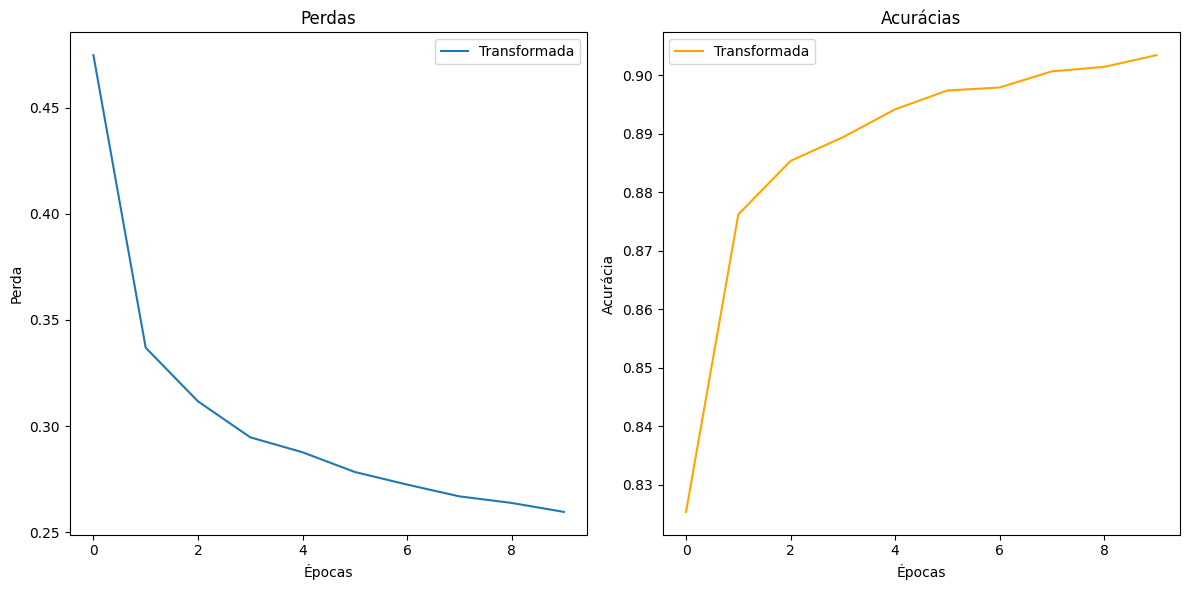

In [29]:
modelo2 = CNN_Model(input_size=28).to(device)
otimizador2 = torch.optim.Adam(modelo2.parameters(), lr=0.01)
perda2 = nn.CrossEntropyLoss()

lista_perdas2, acuracias2 = treino(modelo2, otimizador2, perda2, train_loader_normal, num_epocas=10)
teste(modelo2, test_loader_normal)

plot_side_by_side(lista_perdas2, acuracias2)

In [32]:
print(modelo2.conv1.weight.shape)
print(modelo2.conv2.weight.shape)


torch.Size([32, 1, 3, 3])
torch.Size([64, 32, 3, 3])


In [16]:
del modelo2, otimizador2, perda2
torch.cuda.empty_cache()

EPOCA 1/10
Época 1: Acurácia: 0.50
EPOCA 2/10
Época 2: Acurácia: 0.64
EPOCA 3/10
Época 3: Acurácia: 0.68
EPOCA 4/10
Época 4: Acurácia: 0.70
EPOCA 5/10
Época 5: Acurácia: 0.71
EPOCA 6/10
Época 6: Acurácia: 0.72
EPOCA 7/10
Época 7: Acurácia: 0.72
EPOCA 8/10
Época 8: Acurácia: 0.72
EPOCA 9/10
Época 9: Acurácia: 0.73
EPOCA 10/10
Época 10: Acurácia: 0.73
 >> Acurácia: 0.73


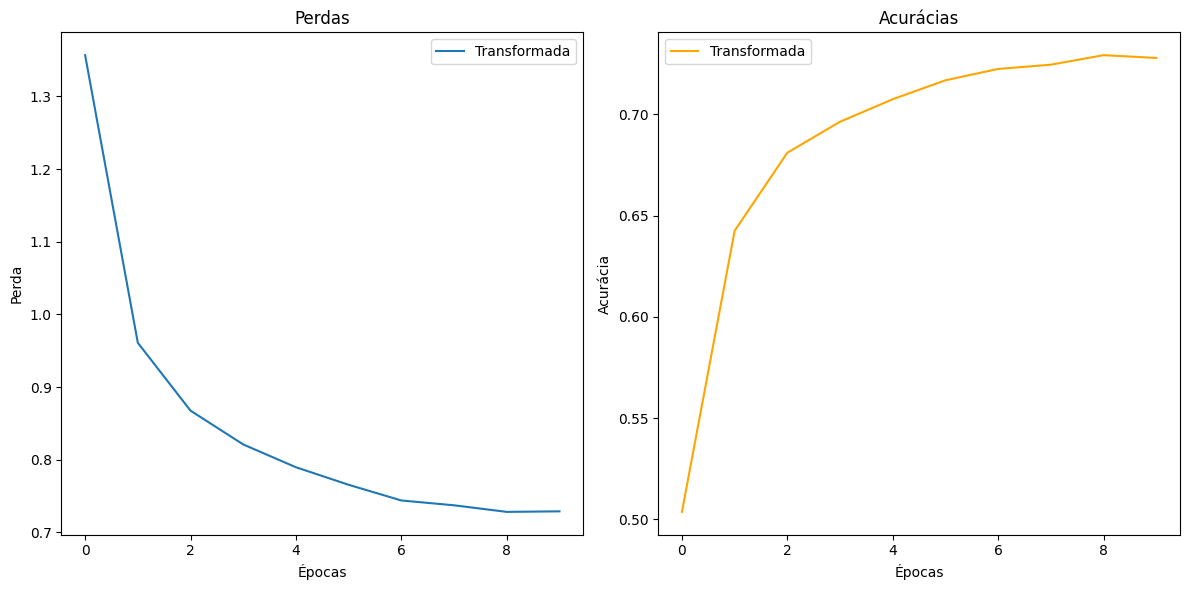

In [26]:
modelo1 = CNN_Model(input_size=84).to(device)
perda = nn.CrossEntropyLoss()
otimizador = torch.optim.Adam(modelo1.parameters(), lr=0.01)

lista_perdas, acuracias = treino(modelo1, otimizador, perda, train_loader, num_epocas=10)
teste(modelo1, test_loader)

plot_side_by_side(lista_perdas, acuracias)